In [ ]:
#try again with backtrader
!pip install backtrader

docs: https://pypi.org/project/backtrader/

__simple xgb-code from earlier simple model exploration as test__

In [1]:
#import required libraries
import pandas as pd

In [2]:
#load lob csv
lob = pd.read_csv('lob.csv')

In [3]:
#drop exchange
lob = lob.drop('Exchange', axis=1)

#ensure 'Timestamp' is treated as a number
lob['Timestamp'] = pd.to_numeric(lob['Timestamp'])
#sort the DataFrame by date and Timestamp to ensure it's in chronological order
lob.sort_values(by=['Date','Timestamp'], inplace=True)

#future mid-price as target
lob['Mid_Price_Future'] = lob['Mid_Price'].shift(-1) 

In [4]:
#interpolate RSI nulls
lob['RSI'] = lob['RSI'].interpolate(method='linear')

#interpolate SMA nulls
lob['SMA_Short'] = lob['SMA_Short'].interpolate(method='linear')
lob['SMA_Long'] = lob['SMA_Long'].interpolate(method='linear')

#intepolate BB nulls
lob['Upper_BB'] = lob['Upper_BB'].interpolate(method='linear')
lob['Lower_BB'] = lob['Lower_BB'].interpolate(method='linear')

#drop any remaining rows with nulls
lob = lob.dropna()

In [5]:
#parsing highest bid, lowest ask, and calc the spread from bid ask 
import ast 

#convert string to lists
lob['Bid'] = lob['Bid'].apply(ast.literal_eval)
lob['Ask'] = lob['Ask'].apply(ast.literal_eval)

#extract features
lob['Highest_Bid'] = lob['Bid'].apply(lambda x: max([b[0] for b in x]))
lob['Lowest_Ask'] = lob['Ask'].apply(lambda x: min([a[0] for a in x]))
lob['Spread'] = lob['Lowest_Ask'] - lob['Highest_Bid']

In [6]:
#scale
from sklearn.preprocessing import StandardScaler

features_to_scale = ['Highest_Bid', 'Lowest_Ask', 'Spread', 'Mid_Price', 'SMA_Short', 'SMA_Long',
                     'EMA_Short', 'EMA_Long', 'RSI', 'Upper_BB', 'Lower_BB', 'Volume', 'OBV',
                     'Mid_Price_Future']

#initialize
scaler = StandardScaler()

#scale
lob[features_to_scale] = scaler.fit_transform(lob[features_to_scale])

In [7]:
#convert to datetime
lob['Date'] = pd.to_datetime(lob['Date'])

#extract dow (0=monday, 6=sunday)
lob['Day_of_Week'] = lob['Date'].dt.dayofweek

In [8]:
#mid price future outliers
#calc Q1, Q3, and IQR
Q1 = lob['Mid_Price_Future'].quantile(0.25)
Q3 = lob['Mid_Price_Future'].quantile(0.75)
IQR = Q3 - Q1

#outlier critieria
outliers_criteria = ((lob['Mid_Price_Future'] < (Q1 - 1.5 * IQR)) | (lob['Mid_Price_Future'] > (Q3 + 1.5 * IQR)))

#filter 
outliers = lob[outliers_criteria]

#remove outliers
lob = lob[~outliers_criteria]

In [9]:
#set split point (as timeseries)
split_point = int(len(lob) * 0.8) 

#split 
train = lob.iloc[:split_point]
test = lob.iloc[split_point:]

X_train = train.drop(['Mid_Price_Future', 'Date', 'Bid', 'Ask'], axis=1)  # Drop non-feature columns
y_train = train['Mid_Price_Future']

X_test = test.drop(['Mid_Price_Future', 'Date', 'Bid', 'Ask'], axis=1)  # Drop non-feature columns
y_test = test['Mid_Price_Future']

In [10]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

#initialize and train
model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
model.fit(X_train, y_train)

#predict
y_pred = model.predict(X_test)

#initial evaluation for comparison to baseline
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse}, R-squared: {r2}')

MSE: 0.12514040060514497, R-squared: 0.14859841523988682


In [ ]:
test.info()

__backtesting__

In [11]:
#prepare data and predictions
import pandas as pd

test_data = test.copy()
test_data['Predicted_Mid_Price_Future'] = y_pred  # Append predictions to the test DataFrame

In [12]:
import pandas as pd

#convert timestamp
test_data['Datetime'] = pd.to_datetime(test_data['Date']) + pd.to_timedelta(test_data['Timestamp'], unit='ms')

#set as index
test_data.set_index('Datetime', inplace=True)

test_data[['Mid_Price', 'Predicted_Mid_Price_Future']].to_csv('backtest_data.csv', index_label='Datetime')

In [13]:
#def trading strategy
import backtrader as bt

class PredictiveStrategy(bt.Strategy):
    params = (
        ('printlog', False),  #enable/disable logging for strategy
    )

    def log(self, txt, dt=None):
        ''' Logging function for the strategy '''
        if self.params.printlog:
            dt = dt or self.datas[0].datetime.date(0)
            print(f'{dt.isoformat()} {txt}')

    def __init__(self):
        self.data_predicted = self.datas[0].Predicted_Mid_Price_Future
        self.data_mid = self.datas[0].Mid_Price

    def next(self):
        if not self.position:  #if not in the market
            if self.data_predicted[0] > self.data_mid[0]:
                self.buy()
                self.log('BUY CREATE, %.2f' % self.data_mid[0])
        else:
            if self.data_predicted[0] <= self.data_mid[0]:
                self.sell()
                self.log('SELL CREATE, %.2f' % self.data_mid[0])

    def stop(self):
        self.log('(Mid Price Prediction Strategy) Ending Value %.2f' % (
            self.broker.getvalue()), dt=self.datas[0].datetime.date(0))


2025-01-06 BUY CREATE, 0.35
2025-01-06 SELL CREATE, 0.32
2025-01-06 BUY CREATE, 0.32
2025-01-06 SELL CREATE, 0.35
2025-01-06 BUY CREATE, 0.35
2025-01-06 SELL CREATE, 0.39
2025-01-06 BUY CREATE, 0.37
2025-01-06 SELL CREATE, 0.41
2025-01-06 BUY CREATE, 0.43
2025-01-06 SELL CREATE, 0.43
2025-01-06 BUY CREATE, 0.44
2025-01-06 SELL CREATE, 0.44
2025-01-06 BUY CREATE, 0.44
2025-01-06 SELL CREATE, 0.44
2025-01-06 BUY CREATE, 0.43
2025-01-06 SELL CREATE, 0.50
2025-01-06 BUY CREATE, 0.44
2025-01-06 SELL CREATE, 0.44
2025-01-06 BUY CREATE, 0.44
2025-01-06 SELL CREATE, 0.67
2025-01-06 BUY CREATE, 0.44
2025-01-06 SELL CREATE, 0.59
2025-01-06 BUY CREATE, 0.39
2025-01-06 SELL CREATE, 0.54
2025-01-06 BUY CREATE, 0.44
2025-01-06 SELL CREATE, 0.56
2025-01-06 BUY CREATE, 0.44
2025-01-06 SELL CREATE, 0.54
2025-01-06 BUY CREATE, 0.44
2025-01-06 SELL CREATE, 0.50
2025-01-06 BUY CREATE, 0.44
2025-01-06 SELL CREATE, 0.48
2025-01-06 BUY CREATE, 0.43
2025-01-06 SELL CREATE, 0.50
2025-01-06 BUY CREATE, 0.39
202

<IPython.core.display.Javascript object>


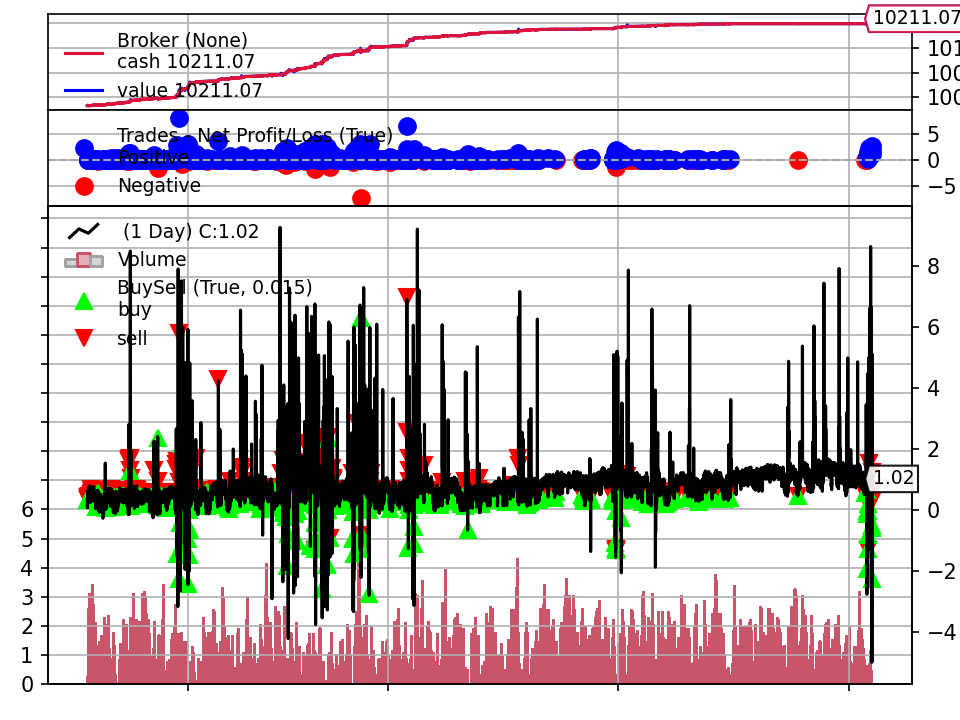

[[<Figure size 640x480 with 4 Axes>]]

In [17]:
#load data into backtrader
from backtrader.feeds import PandasData

class MyPandasData(PandasData):
    
    lines = ('Predicted_Mid_Price_Future', 'Mid_Price')  

    params = (
        ('datetime', None),
        ('Predicted_Mid_Price_Future', -1),
        ('Mid_Price', 'Mid_Price'),
        ('open', 'Mid_Price'),
        ('high', 'Mid_Price'),  #do we need to include converted tape here? 
        ('low', 'Mid_Price'),
        ('close', 'Mid_Price'),
        ('volume', -1),
        ('openinterest', -1),
    )

#data = MyPandasData(dataname=pd.read_csv('backtest_data.csv', parse_dates=True))
data = MyPandasData(dataname=test_data)

#initialise
cerebro = bt.Cerebro()
cerebro.addstrategy(PredictiveStrategy, printlog=True)
cerebro.adddata(data)

#set broker properties
cerebro.broker.set_cash(10000)
cerebro.broker.setcommission(commission=0.001)  #commission rate- can we experiment her?

#backtest
results = cerebro.run()

#plot
cerebro.plot()